<a href="https://colab.research.google.com/github/saritmaitra/BacktestingTradingStrategy/blob/main/NaturalGas_SMA_Backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyforest
from pyforest import *
import warnings
!pip install quandl
import quandl
from pandas import DataFrame
# !pip install tscv
# from tscv import GapKFold
import pandas_datareader as web
from datetime import datetime
!pip install backtrader
import backtrader as bt
from backtrader.feeds import PandasData
!pip install strategies
from strategies import *
import traceback
import sys, logging, json, pprint, requests
import unittest


In [ ]:
def NaturalGasData():
      NaturalGas = quandl.get("CHRIS/CME_NG1", authtoken="LSQpgUzwJRoF667ZpzyL") 
      NaturalGas = NaturalGas.loc['2010-01-01':,]
      NaturalGas = NaturalGas [['Open', 'High', 'Low', 'Last', 'Settle', 'Volume']].copy()
      NaturalGas.rename(columns ={'Last': 'Close', 'Settle': 'AdjClose'}, inplace=True)
      return NaturalGas

NaturalGas = NaturalGasData()

ng = NaturalGas.copy()


ng["10d"] = np.round(ng["AdjClose"].rolling(window = 10, center = False).mean(), 2)
ng["30d"] = np.round(ng["AdjClose"].rolling(window = 30, center = False).mean(), 2)
ng["60d"] = np.round(ng["AdjClose"].rolling(window = 60, center = False).mean(), 2)
 
ng['10d-30d'] = ng['10d'] - ng['30d']
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
ng["Regime"] = np.where(ng['10d-30d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
ng["Regime"] = np.where(ng['10d-30d'] < 0, -1, ng["Regime"])

ng["Signal"] = np.sign(ng["Regime"] - ng["Regime"].shift(1))

 
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
ngSignals = pd.concat([
        pd.DataFrame({"Price": ng.loc[ng["Signal"] == 1, "AdjClose"],
                     "Regime": ng.loc[ng["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": ng.loc[ng["Signal"] == -1, "AdjClose"],
                     "Regime": ng.loc[ng["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
ngSignals.sort_index(inplace = True)
ngLongProfits = pd.DataFrame({
        "Price": ngSignals.loc[(ngSignals["Signal"] == "Buy") &
                                  ngSignals["Regime"] == 1, "Price"],
        "Profit": pd.Series(ngSignals["Price"] - ngSignals["Price"].shift(1)).loc[
            ngSignals.loc[(ngSignals["Signal"].shift(1) == "Buy") & (ngSignals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "endDate": ngSignals["Price"].loc[
            ngSignals.loc[(ngSignals["Signal"].shift(1) == "Buy") & (ngSignals["Regime"].shift(1) == 1)].index
        ].index
    })
 
# plot the candlesticks
fig = go.Figure(data=[go.Candlestick(x=ng.index,
                                     open=ng.Open, 
                                     high=ng.High,
                                     low=ng.Low,
                                     close=ng['AdjClose']), 
                      go.Scatter(x=ng.index, y=ng['10d'], line=dict(color='orange', width=1)),
                      go.Scatter(x=ng.index, y=ng['30d'], line=dict(color='green', width=1)),
                      go.Scatter(x=ng.index, y=ng['60d'], line=dict(color='blue', width=1))
                      ])
fig.update_layout(
    title='Natural Gas (Henry Hub) Physical Futures',
    yaxis_title='Stock price (($/MBtu)')
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
ngLongProfits['2020':]

,Price,Profit,endDate
Date,,,
2020-04-20,1.924,-0.094,2020-05-19
2020-07-10,1.805,0.237,2020-09-17
2020-10-06,2.520,0.172,2020-11-17
2021-01-12,2.753,-0.097,2021-01-26
2021-02-03,2.789,-0.088,2021-03-05


In [ ]:
# We need to get the low of the price during each trade.
tradePeriods = pd.DataFrame({"Start": ngLongProfits.index,"End": ngLongProfits["endDate"]})
ngLongProfits["Low"] = tradePeriods.apply(lambda x: min(ng.loc[x["Start"]:x["End"], "Low"]), axis = 1)
ngLongProfits['2020':]

<IPython.core.display.Javascript object>

,Price,Profit,endDate,Low
Date,,,,
2020-04-20,1.924,-0.094,2020-05-19,1.593
2020-07-10,1.805,0.237,2020-09-17,1.605
2020-10-06,2.520,0.172,2020-11-17,2.466
2021-01-12,2.753,-0.097,2021-01-26,2.414
2021-02-03,2.789,-0.088,2021-03-05,2.681


In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

            Start Port. Value  End Port. Value   End Date  Shares  Share Price  Trade Value  Profit per Share  Total Profit  StopLoss Triggered
2020-04-20             9252.4           9214.8 2020-05-19   400.0        1.924        769.6            -0.094         -37.6                 0.0
2020-07-10             9214.8           9309.6 2020-09-17   400.0        1.805        722.0             0.237          94.8                 0.0
2020-10-06             9309.6           9344.0 2020-11-17   200.0        2.520        504.0             0.172          34.4                 0.0
2021-01-12             9344.0           9324.6 2021-01-26   200.0        2.753        550.6            -0.097         -19.4                 0.0
2021-02-03             9324.6           9307.0 2021-03-05   200.0        2.789        557.8            -0.088         -17.6                 0.0


<IPython.core.display.Javascript object>

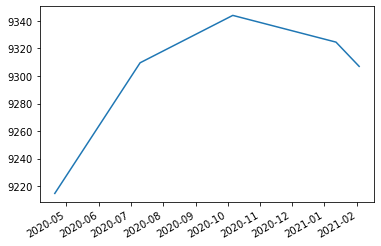

In [ ]:
# Now we have all the information needed to simulate this strategy 
cash = 10000
NGbacktest = pd.DataFrame({"Start Port. Value": [],
                         "End Port. Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         "StopLoss Triggered": []})
port_value = int(0.1)                                                      # Max proportion of portfolio bet on any trade
batch = int(200)                                                           # Number of shares bought per batch
stoploss = int(0.2)                                                        # % of trade loss that would trigger a stoploss
for index, row in ngLongProfits.iterrows():
    batches = np.floor(cash * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
    trade_val = batches * batch * row["Price"]                             # How much money is put on the line with each trade
    if row["Low"] < (1 - stoploss) * row["Price"]:                         # Account for the stop-loss
        share_profit = np.round((1 - stoploss) * row["Price"], 2)
        stop_trig = True
    else:
        share_profit = row["Profit"]
        stop_trig = False
    profit = share_profit * batches * batch # Compute profits
    # Add a row to the backtest data frame containing the results of the trade
    NGbacktest = NGbacktest.append(pd.DataFrame(
        {
                "Start Port. Value": cash,
                "End Port. Value": cash + profit,
                "End Date": row["endDate"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                "StopLoss Triggered": stop_trig
            }, index = [index]))
    cash = max(0, cash + profit)
 
print(NGbacktest['2020':])

NGbacktest['2020':]["End Port. Value"].plot()
plt.show()